In [30]:
import os
import gzip
import anndata as ad
import re
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

PROJECT_PATH = '/home/fichtner/projects/gemmo-tools'
os.chdir(PROJECT_PATH)

DATA_PATH = 'data/datasets/hca_brain-organoids' # softlink to /omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/
DATA_PATH = 'data/datasets/hca_brain-organoids_small'
SAMPLE_CODES = [f for f in os.listdir(DATA_PATH + '/outputs')]
# SAMPLES = ['sSL0146_BrainO_R4_F_10xM_Multiome', 'sSL0136_BrainO_R3_B_10xM_Multiome', 'sSL0170_BrainO_R4_F_10xM_Multiome']
RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'
OUT_FOLDER = os.path.join(PROJECT_PATH, 'data/datasets/hca_brain-organoids_grouped/')



In [2]:
def ct_format(cell_type):
    return cell_type.replace(' ', '-').replace('.', '')

def regex_get(text, pattern=None):
    
    pattern_map = {'sample_name': r'sSL\d*[A-Za-z]*',
                   'barcode': r'^\D*-\d*'}

    if pattern in pattern_map.keys():
        pattern = pattern_map[pattern]
    
    match = re.search(pattern, text)
    return match.group()


def close_multiple_files(file_objects):
    """
    Close multiple files.
    
    :param file_objects: Dictionary of file objects with file names as keys
    """
    for file in file_objects.values():
        file.close()

        
def open_multiple_files(file_names, mode='w'):
    """
    Open multiple files simultaneously as specified by a list of strings.
    
    :param file_names: List of file names (without extensions)
    :param mode: Mode in which to open the files (default is 'w' for write mode)
    :return: Dictionary of file objects with file names as keys
    """
    
    # Check for format
    for name in file_names:
        if (' ' in name) or ('.' in name):
            print('Invalid characters in `file_names`. E.g. space or point.')
            return {}
            
   
    file_objects = {}
    
    for name in file_names:
        
        file_path = os.path.join(OUT_FOLDER, f'{name}_atac_fragments.tsv')
        
        # Ensure file doesn't exists, else abort
        try:
            if os.path.isfile(file_path):
                raise ValueError(f'File: `{file_path}` already exists. ABORTING OPERATION.')
                                                 
        except ValueError as e:
            print(e)
            close_multiple_files(file_objects)
            return {}

        file_objects[name] = open(file_path, mode)

                                 
    return file_objects

In [3]:
# borgs_rna = ad.read_h5ad(DATA_PATH + RNA_AD, backed='r')
borgs_rna = ad.read_h5ad('data/datasets/hca_brain-organoids/' + RNA_AD, backed='r')

In [4]:
# Metadata of cells that passed QC
cells_coldata = borgs_rna.obs[['sample', 'donor', 'celltype_predicted_vertesy']].copy()
cells_coldata['cell_type'] = cells_coldata['celltype_predicted_vertesy'].apply(ct_format)
cells_coldata = cells_coldata.drop('celltype_predicted_vertesy', axis=1)
cells_coldata['barcode'] = [regex_get(i, 'barcode') for i in cells_coldata.index.tolist()]

ann_idxs = cells_coldata.index.tolist()

cell_types = tuple(set(cells_coldata['cell_type']))
cell_types = sorted(cell_types, key=str.upper)

samples = tuple(set(cells_coldata['sample']))
samples = sorted(samples, key=str.upper)

donors = tuple(set(cells_coldata['donor']))
donors = sorted(donors, key=str.upper)

# Note: (indexes ~ cell id) = barcode_sample --> are unique but barcodes aren't

In [40]:
sorted_donors = cells_coldata.groupby('donor').size().reset_index(name='count').sort_values(by='count', ascending=False)
sorted_donors.index = np.linspace(0, len(sorted_donors), len(sorted_donors), dtype=int)

In [42]:
sorted_donors

,donor,count
0,iudw,11948
1,yemz,11355
2,meue,8027
3,hayt,7969
4,laey,7967
...,...,...
67,tixi,1070
68,bima,1029
69,fafq,978
70,hehd,976


In [47]:
sorted_donors[sorted_donors['donor'].isin(['pelm', 'zoxy', 'ualf', 'melw'])]

,donor,count
10,ualf,6659
20,melw,4054
22,pelm,3891
48,zoxy,2241


In [34]:
sorted_groups = cells_coldata.groupby(['donor', 'cell_type']).size().reset_index(name='count').sort_values(by='count', ascending=False)
sorted_groups.index = np.linspace(0, len(sorted_groups), len(sorted_groups), dtype=int)

In [38]:
sorted_groups.loc[50:100]

,donor,cell_type,count
50,iisa,Glia,1263
51,tolg,Stressed-Prog,1218
52,vass,UL-EN,1204
53,qorq,DL-EN,1194
54,hoik,Midbrain-EN,1187
55,sebn,Glia,1170
56,vuna,DL-EN,1162
57,heja,DL-EN,1146
58,kehc,Glia,1133
59,uevq,Stressed-Prog,1130


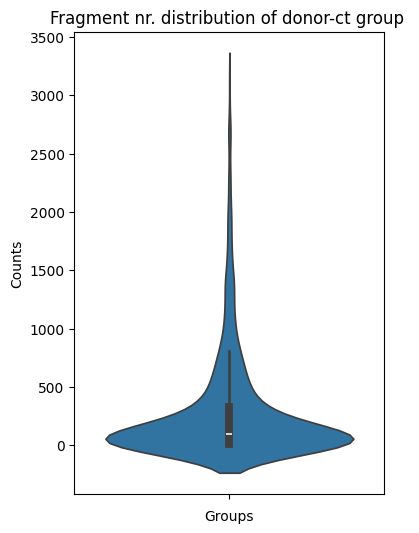

In [28]:
plt.figure(figsize=(4, 6))
sns.violinplot(y=sorted_groups['count'])
plt.xlabel('Groups')
plt.ylabel('Counts')
plt.title('Fragment nr. distribution of donor-ct group ')
plt.show()

In [6]:
# Open output files to write
try:
    
    # Define groups
    groups = [f'{d}_{ct_format(ct)}'
              for d in donors
              for ct in cell_types]

    out_files = open_multiple_files(groups, 'a')


    # Parse each sample file
    for C in SAMPLE_CODES:

        sample = regex_get(C, pattern='sample_name')
        file_path = os.path.join(DATA_PATH, "outputs", C, C, "outs/atac_fragments.tsv.gz")
        
        with gzip.open(file_path, 'rt') as fragments_file:
            
            for line in fragments_file:
                
                if not line.strip().startswith('#'):
                
                    cell_data = line.strip().split('\t')
                    ann_index = f'{cell_data[3]}_{sample}'
                    # print(f'current cell: {ann_index}')

                    if ann_index in ann_idxs:

                        donor, cell_type = cells_coldata.loc[ann_index][['donor', 'cell_type']]
                        # print(f'Passed QC: donor={donor}, cell_type={cell_type}')
                        # print(f'Writing to: {donor}_{cell_type}')
                        out_files[f'{donor}_{cell_type}'].write(line)
                

finally:
    if 'out_files' in locals():
        close_multiple_files(out_files)

KeyboardInterrupt: 